# Seattle Housing Prices - Predictive Modeling

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from itertools import combinations

%run -i "functions/report.py"
%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"
%run -i "functions/add_interactions.py"
%run -i "functions/get_polynomials.py"
%run -i "functions/stepwise.py"
%run -i "functions/rmse_report.py"

### Model Adventure Map:

1. Vanilla model - no scaling or outliers
2. Outliers model - remove pricing outliers
3. Scaled model - min/max scale explanatory variables
4. Interactions model - find and add relevant interactions
5. Polynomial model - add polynomial variables
6. P-Filter Model - use stepwise function


#### Import Model Data

In [5]:
model_data = pd.read_csv('model_data.csv')
model_data.head()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
0,221900.0,3,1180,1.0,0.0,0.0,3,7,0,1955,...,0,1,0,0,0,0,0,0,0,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1,1951,...,0,1,0,0,0,0,1,0,0,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,0,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1,1965,...,0,1,0,0,0,0,1,0,0,0
4,510000.0,3,1680,1.0,0.0,0.0,3,8,0,1987,...,1,0,0,0,0,1,0,0,0,0


In [13]:
model_data[model_data["bedrooms"] == 33]

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
15856,640000.0,33,1620,1.0,0.0,0.0,5,7,1,1947,...,0,1,0,0,0,1,0,0,0,0


In [15]:
model_data= model_data.drop(15856, axis=0)

### Now Train-Test-Split

... in preparation for our baseline model

In [17]:
# Prepping variables for the model
outcome = 'price'
feat_cols = list(model_data.columns)
feat_cols.remove(outcome)

In [18]:
X = model_data[feat_cols]
y = model_data['price']

In [19]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Check lengths
print(len(X_train), len(y_test))
X_train.head()

15117 6479


,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,1.0,3,1200,1.0,0.0,0.0,4,7,0,1969,...,0,0,0,0,0,0,0,0,0,0
19664,1.0,3,1920,1.0,0.0,0.0,3,8,0,2014,...,0,0,0,0,0,0,1,0,0,0
13947,1.0,4,2961,2.0,0.0,0.0,3,9,0,1998,...,1,0,0,0,0,0,1,0,0,0
11172,1.0,3,1320,1.0,0.0,0.0,3,7,0,1986,...,0,0,0,0,0,1,0,0,0,0
12636,1.0,5,3730,1.0,0.0,4.0,4,10,0,1963,...,0,0,0,0,0,0,0,1,0,0


### Model 1: Vanilla

#### Side Note: Model Function

In [20]:
def training_model(y_train, X_train):
    training_model.model = sm.OLS(y_train, X_train).fit()
    return training_model.model.summary()

In [21]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1142.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:06:27   Log-Likelihood:            -2.0422e+05
No. Observations:               15117   AIC:                         4.085e+05
Df Residuals:                   15074   BIC:                         4.089e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.922e+07   4.36e+06    -15.868      0.000   -7.78e+07   -6.07e+07
bedrooms           -2.828e+04   2110.058    -13.403      0.000   -3.24e+04   -2.41e+04
sqft_living          161.3757      3.622     44.557      0.000     154.277     168.475
floors              3.687e+04   3936.621      9.365      0.000    2.91e+04    4.46e+04
waterfront          6.364e+05   1.91e+04     33.371      0.000    5.99e+05    6.74e+05
view                4.683e+04   2257.460     20.746      0.000    4.24e+04    5.13e+04
condition           2.642e+04   2518.271     10.492      0.000    2.15e+04    3.14e+04
grade               8.475e+04   2332.441     36.337      0.000    8.02e+04    8.93e+04
basement           -6498.3107   3683.457     -1.764      0.078   -1.37e+04     721.712
yr_built           -1684.0329     80.058    -21.035      0.000   -1840.957   -1527.109
renovated           5.025e+04   8356.303      6.013      0.000    3.39e+04    6.66e+04
lat                 5.835e+05   2.28e+04     25.576      0.000    5.39e+05    6.28e+05
long               -3.621e+05   3.52e+04    -10.281      0.000   -4.31e+05   -2.93e+05
sqft_living15         30.6668      3.764      8.146      0.000      23.288      38.046
month              -3448.5671    467.556     -7.376      0.000   -4365.033   -2532.101
city_Bellevue       2.102e+05   1.17e+04     17.945      0.000    1.87e+05    2.33e+05
city_Black Diamond  1.287e+05   2.36e+04      5.449      0.000    8.24e+04    1.75e+05
city_Bothell       -1.407e+05   1.97e+04     -7.142      0.000   -1.79e+05   -1.02e+05
city_Carnation      2.482e+04   2.57e+04      0.964      0.335   -2.56e+04    7.53e+04
city_Duvall        -5.634e+04   2.21e+04     -2.544      0.011   -9.98e+04   -1.29e+04
city_Enumclaw       1.568e+05   1.78e+04      8.806      0.000    1.22e+05    1.92e+05
city_Fall City      1.304e+05   2.84e+04      4.586      0.000    7.47e+04    1.86e+05
city_Federal Way   -7.123e+04   1.14e+04     -6.233      0.000   -9.36e+04   -4.88e+04
city_Issaquah       9.169e+04   1.39e+04      6.608      0.000    6.45e+04    1.19e+05
city_Kenmore       -1.608e+05   1.76e+04     -9.121      0.000   -1.95e+05   -1.26e+05
city_Kent          -7638.1158   9753.017     -0.783      0.434   -2.68e+04    1.15e+04
city_Kirkland       4.344e+04   1.34e+04      3.233      0.001    1.71e+04    6.98e+04
city_Maple Valley   7.957e+04   1.33e+04      5.969      0.000    5.34e+04    1.06e+05
city_Medina         9.926e+05   3.39e+04     29.247      0.000    9.26e+05    1.06e+06
city_Mercer Island  3.123e+05   1.59e+04     19.700      0.000    2.81e+05    3.43e+05
city_North Bend      1.76e+05   2.34e+04      7.518      0.000     1.3e+05    2.22e+05
city_Redmond        4.442e+04   1.42e+04      3.121      0.002    1.65e+04    7.23e+04
city_Renton        -1.672e+04   9970.5

In [22]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 178183.12303576607 
 Test RMSE: 186876.51787515875
Percent change:  4.879
Percent change (Base Model vs. Updated Model):  0.27


R-squared isn't bad at 0.759 (adjusted). Based on the initial model, I'm guessing most of the work will be around reducing error as guaged by the RMSE. 

Additionally, we noted during our EDA that there are several collinear variable pairs to be addressed. 

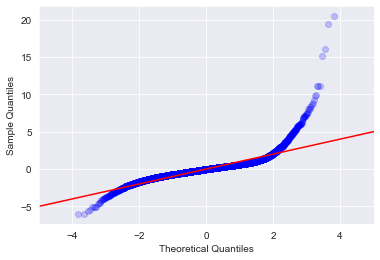

In [23]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

Our QQ plot for the vanilla model shows a non-normal graph with skew especially on the high end where there is likely a long tail of prices.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. Since our focus is on mid-range houses, it is reasonable to price-trim.

P.S. I bet the base model would've been better if it were vanilla bean...

### Model 2: Removing Outliers

Removing outliers based on 2 standard deviations (95%). This is because our business focus is not on the most expensive or the cheapest homes. So in order to improve our model's prediction for relevant prices, we'll narrow our scope.

If we still see a heavy tail, we will further narrow our price range.

#### Filtering price data at 2 standard deviations

In [24]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
pmodel_data = model_data[np.abs(stats.zscore(model_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(model_data.index.difference(pmodel_data.index)))
len(pmodel_data)

841


20755

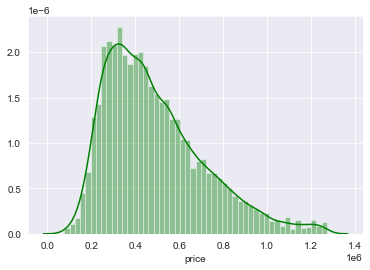

In [25]:
sns.distplot(pmodel_data.price, color='green');

We could try a log-transformation to deal with the skew that still exists. Or we could further narrow the price range. Based on experimentation between the two, we found best results in terms of RMSE reduction when narrowing the price. The trade-off here is a lower R-sqaured value.

#### Further price narrowing to reduce skew and for business case...

In [26]:
pmodel_data = pmodel_data[pmodel_data['price'] <= 790000]

In [27]:
# Reset X and y with new narrowed data
X = pmodel_data[feat_cols]
y = pmodel_data['price']

In [28]:
# Reset TTS since model data was changed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [29]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [30]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     757.6
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:06:39   Log-Likelihood:            -1.6554e+05
No. Observations:               12957   AIC:                         3.312e+05
Df Residuals:                   12914   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -4.25e+07   2.25e+06    -18.883      0.000   -4.69e+07   -3.81e+07
bedrooms           -9007.7999   1142.340     -7.885      0.000   -1.12e+04   -6768.645
sqft_living           67.7366      2.243     30.201      0.000      63.340      72.133
floors              2.978e+04   2091.273     14.240      0.000    2.57e+04    3.39e+04
waterfront           8.65e+04   1.85e+04      4.669      0.000    5.02e+04    1.23e+05
view                2.159e+04   1487.222     14.518      0.000    1.87e+04    2.45e+04
condition           2.151e+04   1299.773     16.550      0.000     1.9e+04    2.41e+04
grade                4.97e+04   1308.054     37.995      0.000    4.71e+04    5.23e+04
basement            6351.6905   1943.108      3.269      0.001    2542.913    1.02e+04
yr_built           -1124.1354     43.428    -25.885      0.000   -1209.261   -1039.009
renovated           1.258e+04   4902.006      2.566      0.010    2968.555    2.22e+04
lat                 4.512e+05   1.14e+04     39.667      0.000    4.29e+05    4.74e+05
long               -1.882e+05   1.81e+04    -10.388      0.000   -2.24e+05   -1.53e+05
sqft_living15         41.1896      2.251     18.298      0.000      36.777      45.602
month              -1885.5724    241.228     -7.817      0.000   -2358.414   -1412.731
city_Bellevue       1.304e+05   6204.994     21.009      0.000    1.18e+05    1.43e+05
city_Black Diamond  1.352e+05   1.14e+04     11.834      0.000    1.13e+05    1.58e+05
city_Bothell        -5.67e+04   9793.498     -5.790      0.000   -7.59e+04   -3.75e+04
city_Carnation      4.209e+04   1.29e+04      3.257      0.001    1.68e+04    6.74e+04
city_Duvall        -3.344e+04    1.1e+04     -3.027      0.002   -5.51e+04   -1.18e+04
city_Enumclaw       1.031e+05   8686.294     11.870      0.000    8.61e+04     1.2e+05
city_Fall City      1.114e+05   1.46e+04      7.652      0.000    8.28e+04     1.4e+05
city_Federal Way   -4.346e+04   5441.435     -7.987      0.000   -5.41e+04   -3.28e+04
city_Issaquah       1.266e+05   6933.643     18.262      0.000    1.13e+05     1.4e+05
city_Kenmore        -8.13e+04   8607.611     -9.445      0.000   -9.82e+04   -6.44e+04
city_Kent          -1.439e+04   4642.218     -3.101      0.002   -2.35e+04   -5294.520
city_Kirkland       3.156e+04   6828.377      4.622      0.000    1.82e+04    4.49e+04
city_Maple Valley   5.585e+04   6476.471      8.624      0.000    4.32e+04    6.85e+04
city_Medina         3.959e+05   8.59e+04      4.607      0.000    2.27e+05    5.64e+05
city_Mercer Island  2.175e+05   1.31e+04     16.581      0.000    1.92e+05    2.43e+05
city_North Bend     1.279e+05   1.17e+04     10.959      0.000    1.05e+05    1.51e+05
city_Redmond        9.597e+04   7107.111     13.504      0.000     8.2e+04     1.1e+05
city_Renton         4881.8472   4805.9

In [31]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 85607.72710045983 
 Test RMSE: 86950.30052802648
Percent change:  1.568
Percent change (Base Model vs. Updated Model):  -51.825


A 51.85% improvement in RMSE as well as better predictability in the test set! Narrowing our price range reduced the error and made for a more normal model set (as seen below with the QQ plot).

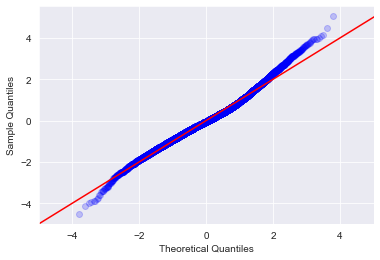

In [32]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 3: Scaling

Scaling after train, test, split to prevent data leakage

In [33]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)


# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

In [34]:
X_train_norm

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
6027,0.0,0.3,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12154,0.0,0.3,0.473723,0.0,0.0,0.0,1.00,0.625,1.0,0.339130,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12610,0.0,0.2,0.196151,0.0,0.0,0.0,0.75,0.500,0.0,0.486957,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6209,0.0,0.3,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4256,0.0,0.2,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20358,0.0,0.2,0.284974,0.4,0.0,0.0,0.50,0.625,0.0,0.991304,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18533,0.0,0.3,0.377498,0.2,0.0,0.0,1.00,0.625,1.0,0.078261,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7244,0.0,0.2,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10798,0.0,0.2,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Fixing the constant after scaling
X_train_norm.drop('const', axis=1, inplace=True)
X_test_norm.drop('const', axis=1, inplace=True)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

In [36]:
training_model(y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     757.6
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:06:47   Log-Likelihood:            -1.6554e+05
No. Observations:               12957   AIC:                         3.312e+05
Df Residuals:                   12914   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.044e+04   9226.088     -7.635      0.000   -8.85e+04   -5.24e+04
bedrooms           -9.008e+04   1.14e+04     -7.885      0.000   -1.12e+05   -6.77e+04
sqft_living          3.66e+05   1.21e+04     30.201      0.000    3.42e+05     3.9e+05
floors              7.445e+04   5228.183     14.240      0.000    6.42e+04    8.47e+04
waterfront           8.65e+04   1.85e+04      4.669      0.000    5.02e+04    1.23e+05
view                8.637e+04   5948.887     14.518      0.000    7.47e+04     9.8e+04
condition           8.604e+04   5199.091     16.550      0.000    7.59e+04    9.62e+04
grade               3.976e+05   1.05e+04     37.995      0.000    3.77e+05    4.18e+05
basement            6351.6905   1943.108      3.269      0.001    2542.913    1.02e+04
yr_built           -1.293e+05   4994.256    -25.885      0.000   -1.39e+05   -1.19e+05
renovated           1.258e+04   4902.006      2.566      0.010    2968.555    2.22e+04
lat                  2.79e+05   7033.618     39.667      0.000    2.65e+05    2.93e+05
long               -2.265e+05   2.18e+04    -10.388      0.000   -2.69e+05   -1.84e+05
sqft_living15       1.759e+05   9614.342     18.298      0.000    1.57e+05    1.95e+05
month              -2.074e+04   2653.503     -7.817      0.000   -2.59e+04   -1.55e+04
city_Bellevue       1.304e+05   6204.994     21.009      0.000    1.18e+05    1.43e+05
city_Black Diamond  1.352e+05   1.14e+04     11.834      0.000    1.13e+05    1.58e+05
city_Bothell        -5.67e+04   9793.498     -5.790      0.000   -7.59e+04   -3.75e+04
city_Carnation      4.209e+04   1.29e+04      3.257      0.001    1.68e+04    6.74e+04
city_Duvall        -3.344e+04    1.1e+04     -3.027      0.002   -5.51e+04   -1.18e+04
city_Enumclaw       1.031e+05   8686.294     11.870      0.000    8.61e+04     1.2e+05
city_Fall City      1.114e+05   1.46e+04      7.652      0.000    8.28e+04     1.4e+05
city_Federal Way   -4.346e+04   5441.435     -7.987      0.000   -5.41e+04   -3.28e+04
city_Issaquah       1.266e+05   6933.643     18.262      0.000    1.13e+05     1.4e+05
city_Kenmore        -8.13e+04   8607.611     -9.445      0.000   -9.82e+04   -6.44e+04
city_Kent          -1.439e+04   4642.218     -3.101      0.002   -2.35e+04   -5294.520
city_Kirkland       3.156e+04   6828.377      4.622      0.000    1.82e+04    4.49e+04
city_Maple Valley   5.585e+04   6476.471      8.624      0.000    4.32e+04    6.85e+04
city_Medina         3.959e+05   8.59e+04      4.607      0.000    2.27e+05    5.64e+05
city_Mercer Island  2.175e+05   1.31e+04     16.581      0.000    1.92e+05    2.43e+05
city_North Bend     1.279e+05   1.17e+04     10.959      0.000    1.05e+05    1.51e+05
city_Redmond        9.597e+04   7107.111     13.504      0.000     8.2e+04     1.1e+05
city_Renton         4881.8472   4805.9

In [37]:
rmse_report(X_train_norm, X_test_norm, y_train, training_model.model)

Train RMSE: 85607.7271004599 
 Test RMSE: 86950.30052802661
Percent change:  1.568
Percent change (Base Model vs. Updated Model):  -51.825


No change after scaling. Based on earlier trials, the later models are improved with scaling as we look at relationships between explanatory variables.

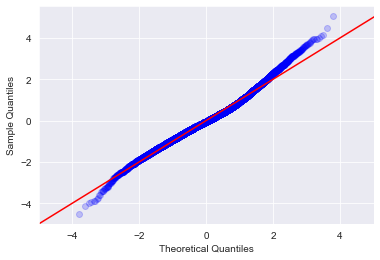

In [38]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 4: Interactions

In [39]:
linreg = LinearRegression()
model_int = linreg.fit(X_train_norm, y_train)

In [40]:
# A function testing for relevant interactions based on highest R-squared
interactions = find_interactions(20, model_int, X_train_norm)

Testing 903 combinations.

R^2 including interaction of long and city_Seattle: 0.718
R^2 including interaction of lat and city_Kirkland: 0.717
R^2 including interaction of yr_built and long: 0.716
R^2 including interaction of yr_built and city_Seattle: 0.715
R^2 including interaction of sqft_living and basement: 0.714
R^2 including interaction of grade and city_Seattle: 0.714
R^2 including interaction of grade and city_Federal Way: 0.714
R^2 including interaction of yr_built and lat: 0.713
R^2 including interaction of yr_built and bath_2: 0.713
R^2 including interaction of sqft_living and view: 0.713
R^2 including interaction of sqft_living and lat: 0.713
R^2 including interaction of sqft_living and city_Federal Way: 0.713
R^2 including interaction of lat and sqft_living15: 0.713
R^2 including interaction of grade and lat: 0.713
R^2 including interaction of grade and city_Kent: 0.713
R^2 including interaction of condition and yr_built: 0.713
R^2 including interaction of bedrooms and fl

In [41]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('yr_built', 'city_Seattle'),
 ('sqft_living', 'basement'),
 ('grade', 'city_Seattle'),
 ('grade', 'city_Federal Way'),
 ('yr_built', 'lat'),
 ('yr_built', 'bath_2'),
 ('sqft_living', 'view'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'city_Federal Way'),
 ('lat', 'sqft_living15'),
 ('grade', 'lat'),
 ('grade', 'city_Kent'),
 ('condition', 'yr_built'),
 ('bedrooms', 'floors'),
 ('bedrooms', 'basement'),
 ('basement', 'sqft_living15'),
 ('basement', 'long')]

Now that we have the list of desired interactions, we will create the new variables and plot their interaction in respect to y.


In [42]:
for inter in interactions:
    var = pd.DataFrame(X_train_norm[inter[0]] * X_train_norm[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    
    # plot this as a grid
#     plt.scatter(var, y_train, c='deepskyblue', alpha=.1)
#     plt.scatter(var, y_pred, c='gold')
#     plt.title('{}*{}'.format(inter[0], inter[1]))
#     plt.show()

In [43]:
# Remove the interactions saved as tuples that do not have a noticeable impact on price based on the graphs above
remove = [('long', 'city_Seattle'),
          ('yr_built', 'city_Seattle')]
for r in remove:
    interactions.remove(r)

In [44]:
len(interactions)

18

In [45]:
# Either simplify or remove this add_interactions function

In [46]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train_norm, X_test_norm)

Interaction Added: lat * city_Kirkland
Interaction Added: grade * city_Seattle
Interaction Added: sqft_living * basement
Interaction Added: yr_built * long
Interaction Added: sqft_living * lat
Interaction Added: yr_built * lat
Interaction Added: condition * yr_built
Interaction Added: sqft_living * view
Interaction Added: yr_built * bath_2
Interaction Added: grade * city_Kent
Interaction Added: bedrooms * floors
Interaction Added: sqft_living * city_Federal Way
Interaction Added: grade * city_Federal Way
Interaction Added: basement * long
Interaction Added: grade * lat
Interaction Added: lat * sqft_living15
Interaction Added: basement * sqft_living15
Interaction Added: bedrooms * basement


In [47]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     599.0
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:07:23   Log-Likelihood:            -1.6497e+05
No. Observations:               12957   AIC:                         3.301e+05
Df Residuals:                   12896   BIC:                         3.305e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -5590.7871   1.76e+04     -0.318      0.750      -4e+04    2.88e+04
bedrooms                       -1.327e+05   1.84e+04     -7.216      0.000   -1.69e+05   -9.67e+04
sqft_living                     3.527e+05   2.98e+04     11.832      0.000    2.94e+05    4.11e+05
floors                          6982.8182   1.16e+04      0.601      0.548   -1.58e+04    2.98e+04
waterfront                       5.92e+04   1.81e+04      3.273      0.001    2.37e+04    9.47e+04
view                            1.641e+05   1.42e+04     11.529      0.000    1.36e+05    1.92e+05
condition                        1.46e+05   1.13e+04     12.893      0.000    1.24e+05    1.68e+05
grade                           2.888e+05   3.16e+04      9.129      0.000    2.27e+05    3.51e+05
basement                        4.701e+04   5994.919      7.841      0.000    3.53e+04    5.88e+04
yr_built                       -8.166e+04    2.2e+04     -3.715      0.000   -1.25e+05   -3.86e+04
renovated                       1.566e+04   4723.781      3.316      0.001    6405.396    2.49e+04
lat                              2.65e+05   1.93e+04     13.717      0.000    2.27e+05    3.03e+05
long                           -4.911e+05   2.96e+04    -16.593      0.000   -5.49e+05   -4.33e+05
sqft_living15                   1.261e+05    2.7e+04      4.662      0.000    7.31e+04    1.79e+05
month                          -2.137e+04   2540.558     -8.411      0.000   -2.63e+04   -1.64e+04
city_Bellevue                   1.533e+05   6156.051     24.905      0.000    1.41e+05    1.65e+05
city_Black Diamond              1.272e+05    1.1e+04     11.599      0.000    1.06e+05    1.49e+05
city_Bothell                   -4.009e+04   9816.138     -4.084      0.000   -5.93e+04   -2.09e+04
city_Carnation                  4.007e+04   1.26e+04      3.174      0.002    1.53e+04    6.48e+04
city_Duvall                    -3.958e+04   1.11e+04     -3.551      0.000   -6.14e+04   -1.77e+04
city_Enumclaw                   9.966e+04   8352.873     11.931      0.000    8.33e+04    1.16e+05
city_Fall City                  1.222e+05    1.4e+04      8.717      0.000    9.47e+04     1.5e+05
city_Federal Way                4.976e+04   2.19e+04      2.275      0.023    6878.114    9.26e+04
city_Issaquah                   1.286e+05   6901.274     18.629      0.000    1.15e+05    1.42e+05
city_Kenmore                    -6.37e+04   8595.962     -7.410      0.000   -8.05e+04   -4.69e+04
city_Kent                       7.377e+04   1.68e+04      4.383      0.000    4.08e+04    1.07e+05
city_Kirkland                   1.505e+06   9.15e+04     16.434      0.000    1.33e+06    1.68e+06
city_Maple Valley                3.52e+04   6323.328      5.567      0.000    2.28e+04    4.76e+04
city_Medina   

In [48]:
rmse_report(X_train2, X_test2, y_train, training_model.model)

Train RMSE: 81875.41939714277 
 Test RMSE: 83206.90730434752
Percent change:  1.626
Percent change (Base Model vs. Updated Model):  -53.926


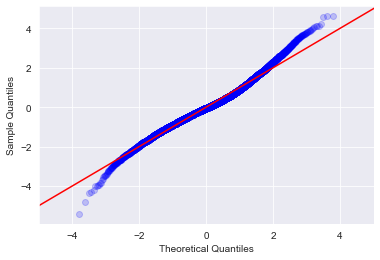

In [49]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [50]:
# Adding interactions decreased RMSE and improved R-squared

### Model: Polynomial Features

In [51]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 2)

In [52]:
poly_feat

[('bedrooms', 2),
 ('sqft_living', 2),
 ('floors', 2),
 ('view', 2),
 ('condition', 2),
 ('grade', 2),
 ('yr_built', 2),
 ('lat', 2),
 ('long', 2),
 ('sqft_living15', 2),
 ('month', 2),
 ('lat * city_Kirkland', 2),
 ('grade * city_Seattle', 2),
 ('sqft_living * basement', 2),
 ('yr_built * long', 2),
 ('sqft_living * lat', 2),
 ('yr_built * lat', 2),
 ('condition * yr_built', 2),
 ('sqft_living * view', 2),
 ('yr_built * bath_2', 2),
 ('grade * city_Kent', 2),
 ('bedrooms * floors', 2),
 ('sqft_living * city_Federal Way', 2),
 ('grade * city_Federal Way', 2),
 ('basement * long', 2),
 ('grade * lat', 2),
 ('lat * sqft_living15', 2),
 ('basement * sqft_living15', 2),
 ('bedrooms * basement', 2)]

In [53]:
#Perform the same function as PolynomialFeatures, but naming the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [54]:
X_train3 = sm.add_constant(X_train3)
X_test3 = sm.add_constant(X_test3)

In [55]:
training_model(y_train, X_train3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     459.2
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:07:32   Log-Likelihood:            -1.6433e+05
No. Observations:               12957   AIC:                         3.288e+05
Df Residuals:                   12867   BIC:                         3.295e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             -6.11e+04   4.03e+04     -1.515      0.130    -1.4e+05    1.79e+04
bedrooms                         -8.609e+04   4.36e+04     -1.973      0.048   -1.72e+05    -578.274
sqft_living                       1.017e+05   7.94e+04      1.281      0.200   -5.39e+04    2.57e+05
floors                           -1.118e+05   2.42e+04     -4.615      0.000   -1.59e+05   -6.43e+04
waterfront                        7.735e+04    1.9e+04      4.067      0.000    4.01e+04    1.15e+05
view                              6.716e+04   3.69e+04      1.820      0.069   -5155.146    1.39e+05
condition                         1.319e+05   4.04e+04      3.264      0.001    5.27e+04    2.11e+05
grade                            -5.581e+05   1.02e+05     -5.469      0.000   -7.58e+05   -3.58e+05
basement                          4.844e+04    1.3e+04      3.719      0.000    2.29e+04     7.4e+04
yr_built                          2.062e+05   6.77e+04      3.047      0.002    7.35e+04    3.39e+05
renovated                         1.999e+04   4525.820      4.418      0.000    1.11e+04    2.89e+04
lat                               1.185e+06   7.86e+04     15.070      0.000    1.03e+06    1.34e+06
long                             -6.073e+05   6.92e+04     -8.776      0.000   -7.43e+05   -4.72e+05
sqft_living15                      2.16e+05   7.71e+04      2.800      0.005    6.48e+04    3.67e+05
month                            -1.197e+04   9214.293     -1.299      0.194      -3e+04    6094.118
city_Bellevue                    -7493.4865   8642.820     -0.867      0.386   -2.44e+04    9447.723
city_Black Diamond                8.497e+04   1.06e+04      8.013      0.000    6.42e+04    1.06e+05
city_Bothell                     -1.453e+05   1.03e+04    -14.149      0.000   -1.65e+05   -1.25e+05
city_Carnation                   -1.366e+05    1.4e+04     -9.779      0.000   -1.64e+05   -1.09e+05
city_Duvall                      -1.772e+05   1.17e+04    -15.123      0.000      -2e+05   -1.54e+05
city_Enumclaw                     2.212e+05   9286.071     23.816      0.000    2.03e+05    2.39e+05
city_Fall City                   -5.994e+04    1.5e+04     -3.997      0.000   -8.93e+04   -3.05e+04
city_Federal Way                  2.443e+04   6.55e+04      0.373      0.709   -1.04e+05    1.53e+05
city_Issaquah                    -3.156e+04   9058.052     -3.484      0.000   -4.93e+04   -1.38e+04
city_Kenmore                     -1.692e+05   9152.993    -18.488      0.000   -1.87e+05   -1.51e+05
city_Kent                         1.047e+05   4.66e+04      2.244      0.025    1.33e+04    1.96e+05
city_Kirkland                     5.661e+05   2.07e+06      0.274      0.784   -3.49e+06    4.62e+06
city_Maple Valley                -3.331e+04   6721.67

In [56]:
rmse_report(X_train3, X_test3, y_train, training_model.model)

Train RMSE: 77962.4843409225 
 Test RMSE: 78929.67814888783
Percent change:  1.241
Percent change (Base Model vs. Updated Model):  -56.128


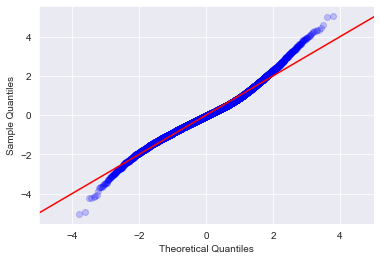

In [57]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### P-Value Filter

In [ ]:
result = stepwise_selection(X_train3, y_train, verbose=True)
print('resulting features:')
print(result)

/Users/stephenenke/Documents/DSC-Project-2/Seattle-Housing-Regression-Analysis/functions/stepwise.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  lat                            with p-value 0.0
Add  lat * sqft_living15^2          with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  grade^2                        with p-value 1.24066e-306
Add  yr_built * lat                 with p-value 6.93568e-204
Add  lat^2                          with p-value 7.75439e-200
Add  const                          with p-value 2.93073e-150
Add  city_Enumclaw                  with p-value 2.74511e-130
Add  city_Renton                    with p-value 3.24641e-94
Add  condition                      with p-value 5.21851e-79
Add  lat * sqft_living15            with p-value 1.72398e-80
Add  grade * city_Kent^2            with p-value 2.03617e-71
Add  yr_built^2                     with p-value 2.04663e-55
Add  view^2                         with p-value 2.76534e-63
Add  grade * lat                    with p-value 5.27073e-58
Add  city_Bellevue                  with p-value 2.92826e-38
Add  city_Mercer Island             with p-

In [45]:
len(result)

63

In [58]:
X_train4 = X_train3.loc[:,result]
X_test4 = X_test3.loc[:,result]
X_train4 = sm.add_constant(X_train4)
X_test4 = sm.add_constant(X_test4)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

crossval = KFold(n_splits = 10, shuffle = True)

In [59]:
training_model(y_train, X_train4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     664.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:45:36   Log-Likelihood:            -1.6431e+05
No. Observations:               12958   AIC:                         3.288e+05
Df Residuals:                   12895   BIC:                         3.292e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.625e+04   3.34e+04     -0.487      0.626   -8.16e+04    4.91e+04
grade * lat                  8.369e+05    1.4e+05      5.970      0.000    5.62e+05    1.11e+06
sqft_living * yr_built^2      2.41e+05    4.5e+04      5.350      0.000    1.53e+05    3.29e+05
yr_built * lat              -7.673e+05    5.5e+04    -13.952      0.000   -8.75e+05   -6.59e+05
grade * lat^2               -6.058e+05   9.75e+04     -6.212      0.000   -7.97e+05   -4.15e+05
view                         1.426e+05   1.37e+04     10.390      0.000    1.16e+05    1.69e+05
city_Bellevue^2              1.312e+04   2297.218      5.709      0.000    8612.583    1.76e+04
city_Bellevue                1.312e+04   2297.218      5.709      0.000    8612.583    1.76e+04
city_Enumclaw                2.419e+05   8716.216     27.754      0.000    2.25e+05    2.59e+05
floors                      -1.001e+05   2.29e+04     -4.382      0.000   -1.45e+05   -5.54e+04
city_Mercer Island           1.083e+05   1.18e+04      9.188      0.000    8.52e+04    1.31e+05
city_Issaquah                1.624e+04   4426.511      3.668      0.000    7558.823    2.49e+04
basement * city_Seattle      1.051e+04   3257.501      3.226      0.001    4122.897    1.69e+04
yr_built * lat^2             4.423e+05   3.67e+04     12.037      0.000     3.7e+05    5.14e+05
city_Kirkland                5.918e+05   4.47e+04     13.235      0.000    5.04e+05    6.79e+05
lat * city_Kirkland^2       -8.135e+05   5.66e+04    -14.381      0.000   -9.24e+05   -7.03e+05
yr_built * long^2           -2.168e+05   1.15e+05     -1.892      0.059   -4.41e+05    7829.306
long                        -7.721e+05   6.44e+04    -11.996      0.000   -8.98e+05   -6.46e+05
city_Black Diamond           1.225e+05      1e+04     12.236      0.000    1.03e+05    1.42e+05
city_Duvall                  -1.25e+05   7765.751    -16.097      0.000    -1.4e+05    -1.1e+05
sqft_living * lat            5.775e+05   9.48e+04      6.091      0.000    3.92e+05    7.63e+05
grade * city_Seattle         2.233e+05   1.77e+04     12.615      0.000    1.89e+05    2.58e+05
sqft_living * lat^2          -5.44e+05   1.11e+05     -4.912      0.000   -7.61e+05   -3.27e+05
bedrooms                    -7.209e+04   9675.070     -7.451      0.000   -9.11e+04   -5.31e+04
city_Kenmore                 -1.43e+05   6642.576    -21.528      0.000   -1.56e+05    -1.3e+05
sqft_living15                2.641e+05   1.96e+04     13.479      0.000    2.26e+05    3.03e+05
month                       -2.087e+04   2409.793     -8.662      0.000   -2.56e+04   -1.61e+04
city_Renton                 -9.793e+04   3577.678    -27.373      0.000   -1.05e+05   -9.09e+04
lat^2                       -6.691e+05   3.35e+04    -19.942      0.000   -7.35e+05   -6.03e+05
lat        

In [60]:
rmse_report(X_train4, X_test4, y_train, training_model.model)

Train RMSE: 77772.56378704724 
 Test RMSE: 78721.96709791309
Percent change:  1.221
Percent change (Base Model vs. Updated Model):  -56.235


In [61]:
linreg = LinearRegression()
model_final = linreg.fit(X_train4, y_train)

************
High Impact Variables:

Variable: grade * lat
Coefficient: 804107.0554313979

Variable: yr_built * lat
Coefficient: -799156.7071081145

Variable: city_Bellevue^2
Coefficient: 1.1066880182318767e+18

Variable: city_Bellevue
Coefficient: -1.1066880182318497e+18

Variable: lat * city_Kirkland^2
Coefficient: -808448.0

Variable: lat
Coefficient: 1149824.0

Variable: long * city_Kent^2
Coefficient: 1018880.0

Variable: sqft_living * floors^2
Coefficient: -1230682.0

Train R^2: 0.7614718257178578
CrossValidated R^2: 0.758080765270026
Test R^2: 0.7546748573809261



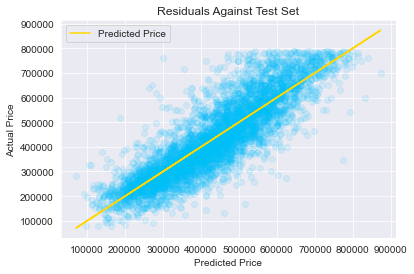

In [62]:
report(model_final, X_train4, X_test4)

And that is where our modeling will end. We've improved the R-squared score by only 0.01 but a high R-squared in the vanilla model can likely be attributed to collinearity in the data.

Our main focus was reducing the error in our pricing predictions which we have done so by nearly $100,000 or a 56.27% improvement. Additionally, we see similar accuracy between the train and testing data. With cross-validation, we find that the predicted prices are even closer to the training data. This points to better generalization of our model when it's released into the wild.

Looking at the plot of predicted price versus actual price, we find the predicted price fits quite well. Towards the upper end of our price range, we do find that the model falls off a bit. We have more confidence in our predictions for prices in the middle of our model's price range.